In [1]:
# Make sure cells are full width of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install pandasql

In [3]:
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

### First, we will process result of megablast analysis. 

The data was generated with the following command:

`blastn -query ecoli_genomes_only.fna -db ecg -outfmt "6 qaccver saccver pident length mismatch gapopen qstart qend qlen sstart send slen" -num_threads 8 > blast.tab `

**Note** that this is a **non standard** list of output fields! 

The resulting file is enormous as it contains many small alignemnts and large amount of self hits. Below we get rid of those.

In [4]:
# Create two filtered down files

# !cat blast.tab | awk '$1!=$2 && $4 > 10000' > blast_10K.tab
!cat blast_10K.tab | awk '$1!=$2 && $4 > 100000' > blast_100K.tab


In [4]:
# Read data in and name columns
bl = pd.read_table("blast_100K.tab",names=['q','t','id','len','mism','gap','qstart','qend','qlen','tstart','tend','tlen'])

In [5]:
bl.head()

,q,t,id,len,mism,gap,qstart,qend,qlen,tstart,tend,tlen
0,U00096.3,CP012868.1,100.000,4641667,1,7,1,4641652,4641652,4641665,1,4641665
1,U00096.3,CP012869.1,99.999,4641686,3,10,1,4641652,4641652,4641684,1,4641684
2,U00096.3,CP012870.1,99.999,4641691,3,12,1,4641652,4641652,4641689,1,4641689
3,U00096.3,CP026028.1,100.000,3340961,2,4,1300694,4641652,4641652,1298718,4639673,4639673
4,U00096.3,CP026028.1,100.000,1040823,1,1,258676,1299498,4641652,257900,1298721,4639673


In [6]:
# Group by target/query combination and compute sum of alignments for each combination and minimum genome length (e.g., min(q,t)). 
bl_max_align_len = pysqldf("select q, t, min(qlen,tlen) as len, sum(len) as align_len from bl group by q, t")

In [7]:
bl_max_align_len.describe()

,len,align_len
count,8.931000e+04,8.931000e+04
mean,4.789096e+06,7.132580e+05
std,2.289110e+05,1.064576e+06
min,3.976195e+06,1.000010e+05
25%,4.624968e+06,1.131720e+05
50%,4.746578e+06,2.433280e+05
75%,4.914884e+06,7.600148e+05
max,5.770602e+06,5.662829e+06


In [8]:
!pip install matplotlib

    100% |████████████████████████████████| 15.0MB 112kB/s eta 0:00:01    88% |████████████████████████████▍   | 13.3MB 27.8MB/s eta 0:00:01
  Using cached pyparsing-2.2.0-py2.py3-none-any.whl
  Using cached cycler-0.10.0-py2.py3-none-any.whl


In [11]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [12]:
bl_max_align_len.plot.box()

NameError: name '_converter' is not defined

In [18]:
bl_filt = pysqldf("select q, t, align_len, len, cast (align_len as float)/len as dist from bl_max_align_len")

In [ ]:
bl_filt['dist'].plot.box()

The problem with `align_len/len` as a distance measure is that it is >1 in some instances. We need to cap it at 1. 

In [19]:
bl_filt = pysqldf("select q, t, align_len, len, min(dist, 1) as dist from bl_filt")

In [ ]:
bl_filt['dist'].plot.box()

In [20]:
bl_filt.head()

,q,t,align_len,len,dist
0,AE014075.1,AP009378.1,448994,4717338,0.095180
1,AE014075.1,CP000247.1,896079,4938920,0.181432
2,AE014075.1,CP000468.1,991805,5082025,0.195159
3,AE014075.1,CP001671.1,3414113,5131397,0.665338
4,AE014075.1,CP001855.1,1251380,4747819,0.263569


Now that the dist is capped at 1, let's convert it into a proper distance by computing  (1 - dist) 

In [21]:
bl_filt = pysqldf("select q, t, align_len, len, 1 - dist as dist from bl_filt")

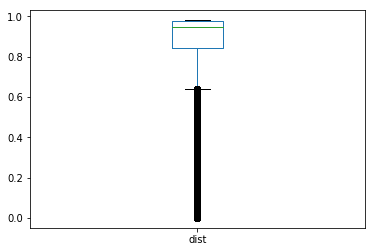

In [17]:
bl_filt['dist'].plot.box()

In [22]:
# Convert three columns of bl_filt to numpy array
dist_as_array = bl_filt[['q','t','dist']].values

In [23]:
dist_as_array[0][0:3]

array(['AE014075.1', 'AP009378.1', 0.9048204729023022], dtype=object)

In [24]:
# Convert numpy array to a dictionary where q ant are keys
dist_as_dict = {}
for row in dist_as_array:
    dist_as_dict[row[1]]={}
    dist_as_dict[row[0]]={}
    
for row in dist_as_array :
    dist_as_dict[row[1]][row[0]]=row[2]

In [25]:
dist_as_dict['AE014075.1']

{'AP009378.1': 0.90482026091834,
 'CP000247.1': 0.8185678245446373,
 'CP000468.1': 0.8048405901190963,
 'CP001671.1': 0.3346620813006672,
 'CP001855.1': 0.7364305589577025,
 'CP001969.1': 0.8362648219602955,
 'CP002167.1': 0.8169796473592198,
 'CP002211.1': 0.29029177200794065,
 'CP002212.1': 0.29029177200794065,
 'CP005930.1': 0.9001751047006817,
 'CP006784.1': 0.930065821458271,
 'CP006830.1': 0.8274326844257384,
 'CP007149.1': 0.8316949830156941,
 'CP007275.1': 0.8000899899475912,
 'CP007799.1': 0.48964814196047424,
 'CP009072.1': 0.3791435081733394,
 'CP010151.1': 0.867846271210292,
 'CP010876.1': 0.9284042496294067,
 'CP011915.1': 0.8247379218218895,
 'CP012379.1': 0.8104253661150395,
 'CP012625.1': 0.8337189534337235,
 'CP012631.1': 0.82502116712901,
 'CP012633.1': 0.8412290708011995,
 'CP012635.1': 0.8290066464708612,
 'CP013658.1': 0.9297470637375256,
 'CP013831.1': 0.954612321835492,
 'CP013835.1': 0.9322329580662534,
 'CP013837.1': 0.9515889428646908,
 'CP014316.1': 0.9293930

In [26]:
# Covert it to a matrix
dist_matrix = pd.DataFrame(dist_as_dict).T.fillna(1)

In [27]:
dist_matrix.head()

,AE014075.1,AM946981.2,AP009048.1,AP009240.1,AP009378.1,AP010953.1,AP010960.1,AP012030.1,AP012306.1,AP017610.1,...,LM995446.1,LN832404.1,LT601384.1,LT615377.1,LT615378.1,LT838196.1,LT883142.1,LT903847.1,LT906474.1,U00096.3
AE014075.1,1.00000,1.000000,1.000000,1.000000,0.90482,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.949982,1.000000,1.000000
AM946981.2,1.00000,1.000000,0.974699,1.000000,1.00000,1.000000,1.000000,1.000000,0.972939,1.000000,...,0.974699,0.974699,0.970476,0.974699,0.974699,0.850059,0.885097,1.000000,0.911871,0.974699
AP009048.1,1.00000,0.974699,1.000000,0.969072,1.00000,0.977681,0.977681,0.172585,0.478005,0.977665,...,0.189135,0.179722,0.738840,0.179722,0.179723,0.673971,0.872128,1.000000,0.791710,0.043604
AP009240.1,1.00000,1.000000,0.969072,1.000000,1.00000,0.908196,0.898895,1.000000,0.964164,1.000000,...,0.968662,0.969017,1.000000,0.969017,0.969017,1.000000,1.000000,1.000000,1.000000,0.969041
AP009378.1,0.90482,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.978793,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
%load_ext rpy2.ipython

In [24]:
%%R
library(ape)

In [25]:
%%R
library(ggtree)

/home/anton/miniconda3/envs/jupyter3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/anton/miniconda3/envs/jupyter3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: If you use ggtree in published research, please cite:

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data.
Methods in Ecology and Evolution 2016, doi:10.1111/2041-210X.12628



  warnings.warn(x, RRuntimeWarning)
/home/anton/miniconda3/envs/jupyter3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘ggtree’


  warnings.warn(x, RRuntimeWarning)
/home/anton/miniconda3/envs/jupyter3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:

In [26]:
from rpy2 import robjects as ro
ro.globalenv['dist_matrix'] = dist_matrix

In [27]:
%R -i dist_matrix

In [28]:
dist_matrix

,AE014075.1,AM946981.2,AP009048.1,AP009240.1,AP009378.1,AP010953.1,AP010960.1,AP012030.1,AP012306.1,AP017610.1,...,LM995446.1,LN832404.1,LT601384.1,LT615377.1,LT615378.1,LT838196.1,LT883142.1,LT903847.1,LT906474.1,U00096.3
AE014075.1,1.000000,1.000000,1.000000,1.000000,0.904820,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.949982,1.000000,1.000000
AM946981.2,1.000000,1.000000,0.974699,1.000000,1.000000,1.000000,1.000000,1.000000,0.972939,1.000000,...,0.974699,0.974699,0.970476,0.974699,0.974699,0.850059,0.885097,1.000000,0.911871,0.974699
AP009048.1,1.000000,0.974699,1.000000,0.969072,1.000000,0.977681,0.977681,0.172585,0.478005,0.977665,...,0.189135,0.179722,0.738840,0.179722,0.179723,0.673971,0.872128,1.000000,0.791710,0.043604
AP009240.1,1.000000,1.000000,0.969072,1.000000,1.000000,0.908196,0.898895,1.000000,0.964164,1.000000,...,0.968662,0.969017,1.000000,0.969017,0.969017,1.000000,1.000000,1.000000,1.000000,0.969041
AP009378.1,0.904820,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978793,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
AP010953.1,1.000000,1.000000,0.977681,0.908196,1.000000,1.000000,0.637579,1.000000,0.973919,1.000000,...,0.977385,0.977641,1.000000,0.977641,0.977641,1.000000,1.000000,1.000000,1.000000,0.977658
AP010960.1,1.000000,1.000000,0.977681,0.898894,1.000000,0.637578,1.000000,1.000000,0.973919,1.000000,...,0.977385,0.977641,1.000000,0.977641,0.977641,1.000000,1.000000,1.000000,1.000000,0.977658
AP012030.1,1.000000,1.000000,0.172585,1.000000,1.000000,1.000000,1.000000,1.000000,0.435220,1.000000,...,0.125893,0.258484,0.693229,0.258484,0.258484,0.640481,0.924987,1.000000,0.719654,0.123393
AP012306.1,1.000000,0.972939,0.478005,0.964164,1.000000,0.973919,0.973919,0.435220,1.000000,0.973901,...,0.340827,0.426137,0.684259,0.426137,0.426137,0.647874,0.891031,1.000000,0.742681,0.376076
AP017610.1,1.000000,1.000000,0.977665,1.000000,0.978793,1.000000,1.000000,1.000000,0.973901,1.000000,...,0.977370,0.977626,1.000000,0.977626,0.977626,1.000000,0.978139,1.000000,1.000000,0.977643


In [30]:
%R njdistmat=nj(data.matrix(dist_matrix))

R object with classes: ('phylo',) mapped to:
<ListVector - Python:0x7fd3489babc8 / R:0xccb4ae8>
[Matrix, FloatVector, StrVector, IntVector]
  edge: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7fd34e9c8688 / R:0xc61b870>
[     446,      458,      482, ...,      356,      107,       17]
  edge.length: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7fd348b6eec8 / R:0xc7a59b0>
[0.012413, 0.029619, 0.020963, ..., 0.318154, 0.371642, 0.443056]
  tip.label: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7fd3488dda88 / R:0xccd54c0>
['AE01..., 'AM94..., 'AP00..., ..., 'LT90..., 'LT90..., 'U000...]
  Nnode: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x7fd3488ddec8 / R:0xd34d8d8>
[     443]

In [31]:
%R dat=fortify(njdistmat)

,node,parent,branch.length,x,y,label,isTip,branch,angle
1,1,700,1.847029e-01,0.500227,4.000000,AE014075.1,1,0.407876,2.828283
2,2,878,-1.620737e-08,0.508453,329.000000,AM946981.2,1,0.508453,265.858586
3,3,633,3.908499e-02,0.491331,415.000000,AP009048.1,1,0.471789,334.545455
4,4,560,2.768841e-01,0.473763,274.000000,AP009240.1,1,0.335321,221.414141
5,5,769,6.388150e-02,0.497910,41.000000,AP009378.1,1,0.465969,32.727273
6,6,718,1.225745e-01,0.496165,181.000000,AP010953.1,1,0.434878,145.050505
7,7,603,2.209601e-01,0.495792,183.000000,AP010960.1,1,0.385312,147.474747
8,8,681,-2.184466e-03,0.496472,398.000000,AP012030.1,1,0.497564,320.808081
9,9,579,2.715285e-01,0.489076,388.000000,AP012306.1,1,0.353311,313.131313
10,10,706,1.580681e-01,0.497213,113.000000,AP017610.1,1,0.418179,90.909091


In [32]:
%R dat$group<-'no'

array(['no'], dtype='<U2')

In [33]:
%%R
for (i in range(1,length(dat['node'])))
    if (dat[i,'label']=='CP020543.1')
        dat[i,'group']<-'yes'
        print('ok ')
    if (dat[i,'label']=='CP024090.1')
        dat[i,'group']<-'yes'
        print('ok ')

[1] "ok "
[1] "ok "


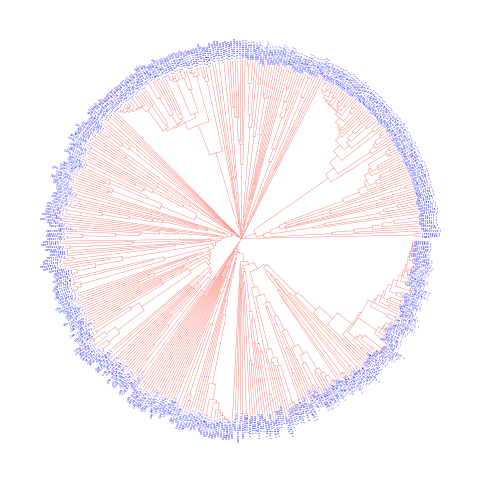

In [50]:
%%R
ggtree(dat,aes(x,y,color=group),size=0.2, layout="fan")+geom_tiplab2(size=1,color="blue")

In [45]:
%R ggtree(dat)

R object with classes: ('gg', 'ggplot') mapped to:
<ListVector - Python:0x7fd3487c8188 / R:0xdf4aba8>
[DataF..., ListV..., Envir..., ..., Envir..., Envir..., ListV...]
R object with classes: ('gg', 'ggplot') mapped to:
<ListVector - Python:0x7fd3487c8188 / R:0xdf4aba8>
[DataF..., ListV..., Envir..., ..., Envir..., Envir..., ListV...]
R object with classes: ('gg', 'ggplot') mapped to:
<ListVector - Python:0x7fd3487c8188 / R:0xdf4aba8>
[DataF..., ListV..., Envir..., ..., Envir..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('ScalesList', 'ggproto') mapped to:
<Environment - Python:0x7fd3487c8848 / R:0xcdab840>
  ...
  data: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('FacetNull', 'Facet', 'ggproto') mapped to:
<Environment - Python:0x7fd3487cb888 / R:0xe5e9920>
  layers: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('environment',) mapped to:
<Environment - Python:0x7f

In [28]:
# Convert matrix (a dataframe) to an array
matrix = dist_matrix.values.tolist()

In [29]:
# Retrieve names
names = list(dist_matrix.columns.values)

In [30]:
matrix[0][1]

1.0

In [31]:
!pip install biopython

In [31]:
len(names)
len(matrix)

445

In [32]:
# Convert matrix from a fill square into lower triangle
matrix_lt = []
for i, row in enumerate(matrix):
    matrix_lt.append(row[:(i+1)])

In [33]:
import Bio
import Bio.Phylo.TreeConstruction as tc

In [34]:
# Initialize Bio distance matrix using names and lower traingle
dm = tc.DistanceMatrix(names, matrix_lt)

In [35]:
# Compute phylogenetic tree using NJ
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

In [37]:
!conda install -y -c conda-forge pygraphviz 

Fetching package metadata ...............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda:
#
pygraphviz                1.4rc1                   py36_0    conda-forge


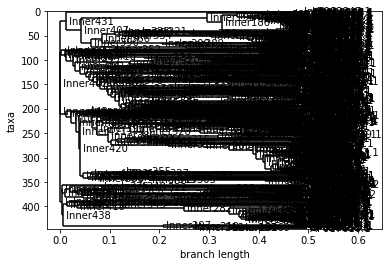

In [37]:
%matplotlib inline  
from Bio import Phylo
Phylo.draw(tree)

In [39]:
import pylab

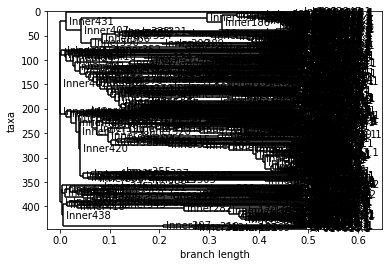

In [40]:
%matplotlib inline  
import matplotlib.pyplot as plt
Phylo.draw(tree)
pylab.show(tree)

In [41]:
Phylo.draw_ascii(tree)

                                                          _ LT903847.1
   ______________________________________________________|
  |                                                      |_ FM180568.1
  |
  |                                 _______________________ CP021207.1
  |                                |
  |                                |       ________________ CP018970.1
  |                                |      |
  |                                |      |             ___ CP014522.1
  |                                |      |      ______|
  |                                |      |     |      |___ CP014495.1
  |                                |      |    ,|
  |                                |      |    ||  _______ CP019008.1
  |                                |   ___|    ||_|
  |                                |  |   |    |  |    ___ CP019020.1
  |                                |  |   |  __|  |___|
  |                                |  |   | |  |      |____ CP014488.1
  | 

In [38]:
Phylo.write(tree,'ecoli.nwk', 'newick')

1

In [ ]:
!conda install -y -c etetoolkit ete3 ete_toolchain

In [49]:
from ete3 import Tree, TreeStyle

In [50]:
t = Tree("ecoli.nwk", format=1)
ts = TreeStyle()
ts.mode="c"

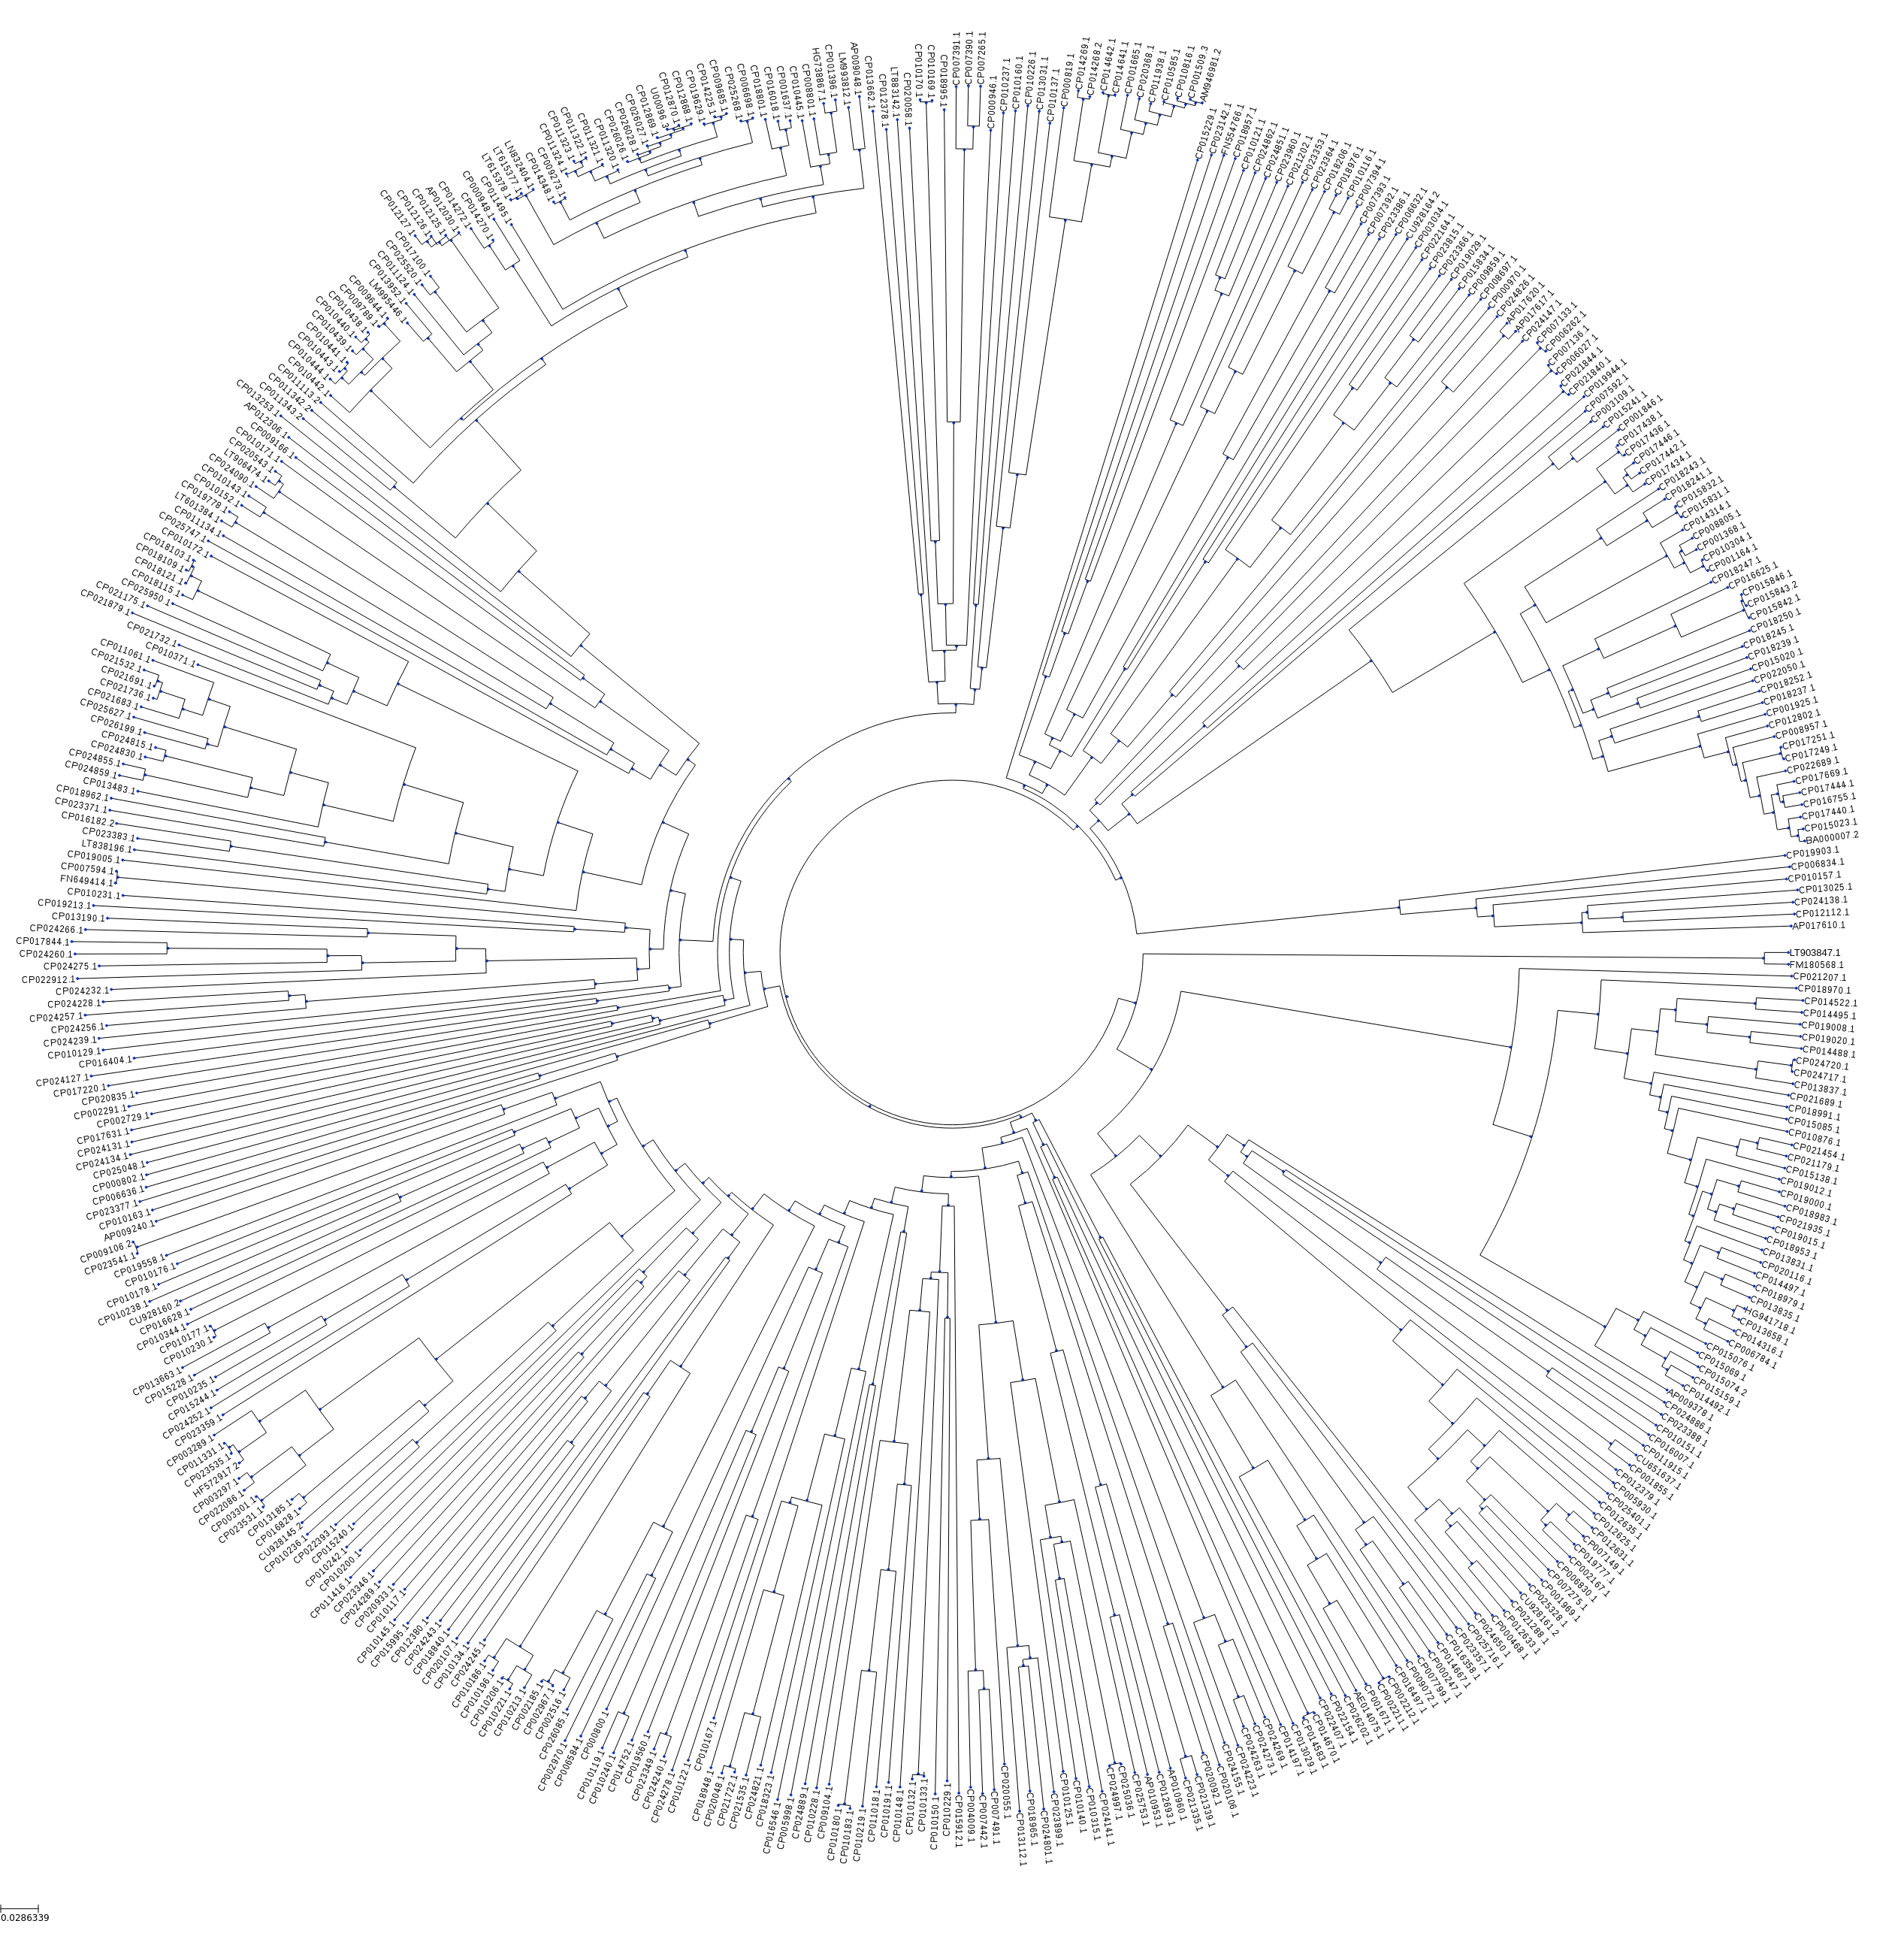

In [52]:
t.render("%%inline", tree_style=ts)